In [1]:
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
from keras.models import load_model
import pickle
from tensorflow.keras.optimizers import Adam 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tqdm import tqdm
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed(31415)

# Loading and preprocessing data

In [2]:
# Data Pipeline
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    image = tf.image.per_image_standardization(image)
    return image, label

In [3]:
image_size = (48, 48)
# Load training, validation and test sets
ds_train_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test_ = image_dataset_from_directory(
    'test',
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=False,
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val = (
    ds_val_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test = (
    ds_test_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-20 23:49:59.686731: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-20 23:49:59.686871: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [4]:
# to use the pretrained model
image_size = (224, 224)
# Load training, validation and test sets
ds_train_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="training",
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_val_ = image_dataset_from_directory(
    'train',
    validation_split=0.2,
    seed=123,
    subset="validation",
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=True,
)
ds_test_ = image_dataset_from_directory(
    'test',
    image_size=image_size,
    # batck_size = 128,
    interpolation = 'nearest',
    labels='inferred',
    shuffle=False,
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train_224 = (
    ds_train_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_val_224 = (
    ds_val_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_test_224 = (
    ds_test_
    .map(preprocess)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


# Getting insights

In [5]:
class_names = np.array(ds_train_.class_names)
print('There are\033[1m {}\033[0m classes:\033[1m'.format(len(class_names)))
for class_name in class_names:
    print('\t'+class_name.upper())
print("\033[0m", end="")

There are 7 classes:
	ANGRY
	DISGUST
	FEAR
	HAPPY
	NEUTRAL
	SAD
	SURPRISE


In [6]:
y_train = np.concatenate([y for x, y in ds_train], axis=0)
y_val = np.concatenate([y for x, y in ds_val], axis=0)
y_test = np.concatenate([y for x, y in ds_test], axis=0)

2023-03-20 23:50:03.022733: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


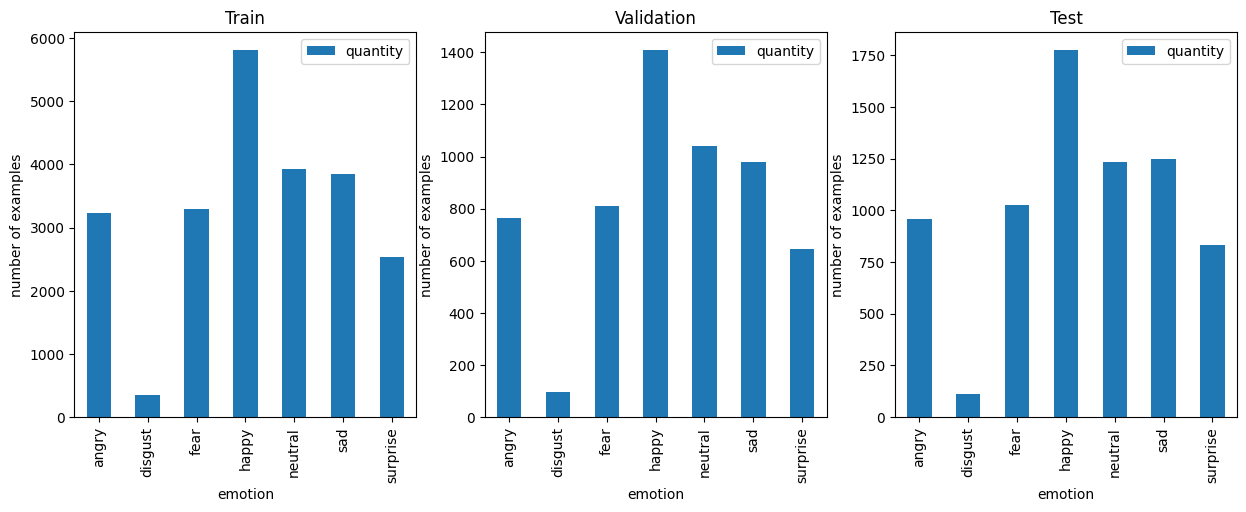

In [7]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
pd.DataFrame({'emotion':class_names[y_train], 'quantity': np.ones(y_train.shape)}).groupby('emotion').count().plot(ax=axes[0], kind='bar')
pd.DataFrame({'emotion':class_names[y_val], 'quantity': np.ones(y_val.shape)}).groupby('emotion').count().plot(ax=axes[1], kind='bar')
pd.DataFrame({'emotion':class_names[y_test], 'quantity': np.ones(y_test.shape)}).groupby('emotion').count().plot(ax=axes[2], kind='bar');

titles = ['Train','Validation','Test']
for i in range(3):
    axes[i].set_title(titles[i])
    axes[i].set_ylabel('number of examples'); 

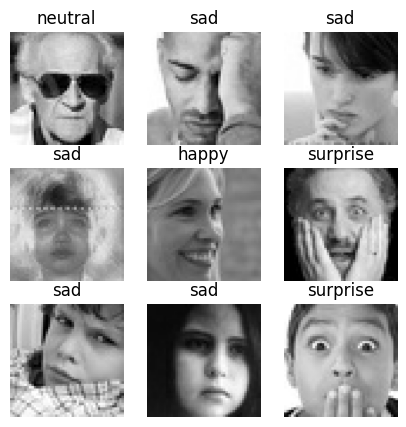

In [8]:
plt.figure(figsize=(5, 5))
for images, labels in ds_train_.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off");

# Pretrained model

In [ ]:
model = tf.keras.Sequential([
                                hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
                                            trainable=False),
                                tf.keras.layers.Dense(len(class_names), activation='softmax')
                            ])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [9]:
# history = model.fit(
#     ds_train_224,
#     validation_data=ds_val_224,
#     epochs=30,
# )
# model.save('models/my_model.h5')
# with open('models/history.pkl', 'wb') as f:
#     pickle.dump(history.history, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1024)              1529968   
                                                                 
 dense (Dense)               (None, 7)                 7175      
                                                                 
Total params: 1,537,143
Trainable params: 7,175
Non-trainable params: 1,529,968
_________________________________________________________________
Epoch 1/30


/Users/alvar/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2023-03-20 23:50:15.857822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - ETA: 0s - loss: 1.7809 - accuracy: 0.2685

2023-03-20 23:50:58.546226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 55s 73ms/step - loss: 1.7809 - accuracy: 0.2685 - val_loss: 1.7163 - val_accuracy: 0.3005
Epoch 2/30
718/718 [==============================] - 48s 67ms/step - loss: 1.6871 - accuracy: 0.3225 - val_loss: 1.6628 - val_accuracy: 0.3329
Epoch 3/30
718/718 [==============================] - 48s 67ms/step - loss: 1.6459 - accuracy: 0.3495 - val_loss: 1.6318 - val_accuracy: 0.3534
Epoch 4/30
718/718 [==============================] - 49s 69ms/step - loss: 1.6192 - accuracy: 0.3635 - val_loss: 1.6106 - val_accuracy: 0.3684
Epoch 5/30
718/718 [==============================] - 50s 70ms/step - loss: 1.5996 - accuracy: 0.3757 - val_loss: 1.5948 - val_accuracy: 0.3801
Epoch 6/30
718/718 [==============================] - 49s 69ms/step - loss: 1.5843 - accuracy: 0.3824 - val_loss: 1.5824 - val_accuracy: 0.3869
Epoch 7/30
718/718 [==============================] - 50s 70ms/step - loss: 1.5716 - accuracy: 0.3896 - val_loss: 1.5722 - val_accuracy: 0.3900
Epo

In [12]:
model = load_model('models/my_model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
with open('models/history.pkl', 'rb') as f:
    history2 = pickle.load(f)

In [11]:
def evaluate(model,history,ds_train,ds_val,ds_test):
    f,axes = plt.subplots(1,2,figsize=(20,5))
    history_frame = pd.DataFrame(history)
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=axes[0])
    history_frame.loc[:, ['accuracy', 'val_accuracy']].plot(ax=axes[1]);

    print("Calculating training results:")
    y_train_predictions = np.argmax(model.predict(ds_train),axis=1)
    print("Calculating validation results:")
    y_val_predictions = np.argmax(model.predict(ds_val),axis=1)
    print("Calculating test results:")
    y_test_predictions = np.argmax(model.predict(ds_test),axis=1)

    f, axes= plt.subplots(1,3,figsize=(20,5))
    accuracies = []
    accuracies.append(round(100*accuracy_score(y_train, y_train_predictions),2))
    mat = confusion_matrix(y_train, y_train_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[0]);

    accuracies.append(round(100*accuracy_score(y_val, y_val_predictions),2))
    mat = confusion_matrix(y_val, y_val_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[1]);

    accuracies.append(round(100*accuracy_score(y_test, y_test_predictions),2))
    mat = confusion_matrix(y_test,y_test_predictions)
    sns.heatmap(mat, annot=True, fmt='g', ax=axes[2]);

    for i in range(3):
        axes[i].set_xlabel('Predicted emotions');axes[i].set_ylabel('True emotions'); 
        axes[i].set_title('Confusion Matrix '+titles[i]+ " (accuracy: {}%)".format(accuracies[i])); 
        axes[i].xaxis.set_ticklabels(class_names); axes[i].yaxis.set_ticklabels(class_names);

Calculating training results:


2023-03-21 00:17:25.991084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 37s 49ms/step
Calculating validation results:
180/180 [==============================] - 9s 52ms/step
Calculating test results:
225/225 [==============================] - 13s 55ms/step


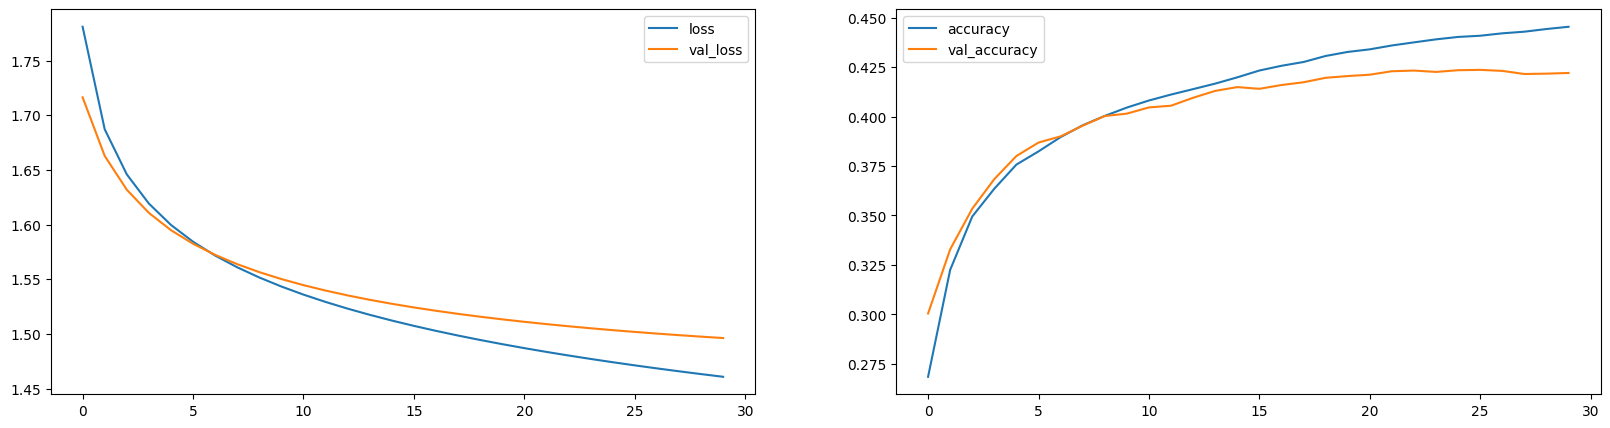

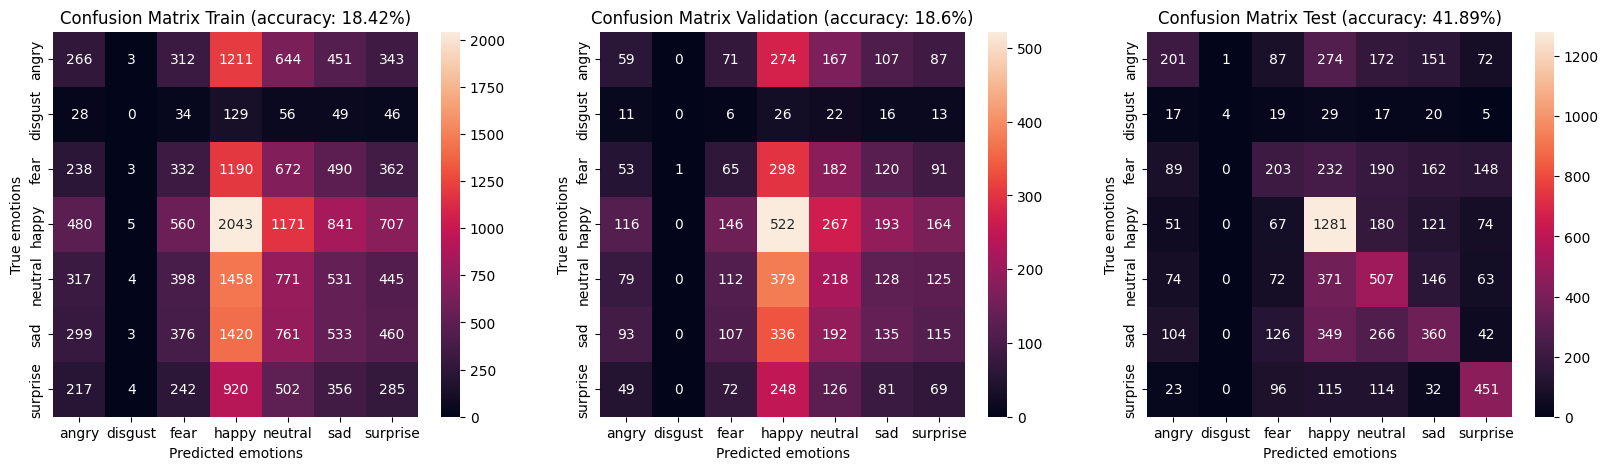

In [13]:
evaluate(model,history2,ds_train_224,ds_val_224,ds_test_224)

### There are very few "disgust" examples so they're the most difficult ones to predict, on the other hand "happy" is widely represented so it predicts them very well

# Customized CNN

In [17]:
model= tf.keras.models.Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    Conv2D(64,(3,3), padding='same', activation='relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),
        
    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),
        
    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(7, activation='softmax')
])
model.build([None, 48, 48, 3])
model.summary()
model.compile(
    optimizer=Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)      

/Users/alvar/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [18]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=30,
)
model.save('models/my_model_custom.h5')
with open('models/history_custom.pkl', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/30


2023-03-21 00:21:18.244525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - ETA: 0s - loss: 8.9933 - accuracy: 0.2606

2023-03-21 00:22:12.388023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


718/718 [==============================] - 59s 80ms/step - loss: 8.9933 - accuracy: 0.2606 - val_loss: 8.5656 - val_accuracy: 0.2923
Epoch 2/30
718/718 [==============================] - 56s 78ms/step - loss: 7.3350 - accuracy: 0.4689 - val_loss: 7.2418 - val_accuracy: 0.3498
Epoch 3/30
718/718 [==============================] - 57s 79ms/step - loss: 5.6421 - accuracy: 0.7668 - val_loss: 6.0398 - val_accuracy: 0.4031
Epoch 4/30
220/718 [========>.....................] - ETA: 37s - loss: 4.6276 - accuracy: 0.9232

# Data augmentation

In [14]:
with tf.device('/cpu:0'):
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=(-0.2,0,2))
    ])
    ds_train_augmented = ds_train.map(
        lambda x, y: (data_augmentation(x), y)
    )
    ds_val_augmented = ds_val.map(
        lambda x, y: (data_augmentation(x), y)
    )